In [1]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime
# import pipeline
import pickle
# from config import Config

%load_ext tensorboard

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# Parameters Based on Paper
epsilon = 1e-7
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
alpha = 0.0005
epochs = 10
no_of_secondary_capsules = 10
hidden_units = 10

optimizer = tf.keras.optimizers.Adam()

In [4]:
params = {
    "no_of_conv_kernels": 256,
    "no_of_primary_capsules": 32,
    "no_of_secondary_capsules": 10,
    "primary_capsule_vector": 8,
    "secondary_capsule_vector": 16,
    "r":3,
}

In [5]:
checkpoint_path = 'D:\year-end-project/models/final/encoder_devnagari_32x32_10_similarity/model/capsule'

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = 'D:\year-end-project/models/final//encoder_devnagari_10_similarity/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

scalar_logdir = 'D:\year-end-project/models/final//encoder_devnagari_10_similarity/scalars/%s' % stamp
file_writer = tf.summary.create_file_writer(scalar_logdir + "/metrics")

In [6]:
with open(r'D:\year-end-project\models\final\code\devnagri_10\devnagri_32x32_10.pkl', 'rb') as f:
    data = pickle.load(f)
X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]

In [7]:
num_copies = 5
X_train = np.repeat(X_train, num_copies, axis=0)
y_train = np.repeat(y_train, num_copies)
X_test = np.repeat(X_test, num_copies, axis=0)
y_test = np.repeat(y_test, num_copies)
print(X_train.shape)

(89250, 32, 32)


In [8]:
print(X_test.shape,X_train.shape)
with tf.device('/GPU:0'):
    X_train = X_train / 255.0
    X_train = tf.cast(X_train, dtype=tf.float32)
    X_train = tf.expand_dims(X_train, axis=-1)

    X_test = X_test / 255.0
    X_test = tf.cast(X_test, dtype=tf.float32)
    X_test = tf.expand_dims(X_test, axis=-1)

(15750, 32, 32) (89250, 32, 32)


In [9]:
testing_dataset_size = X_test.shape[0]
training_dataset_size = X_train.shape[0]

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size=64)

In [11]:
testing = tf.data.Dataset.from_tensor_slices((X_test, y_test))
testing = testing.batch(batch_size=64)

In [12]:
X_train.shape

TensorShape([89250, 32, 32, 1])

In [13]:
class CapsuleNetwork(tf.keras.Model):
    def __init__(self, no_of_conv_kernels, no_of_primary_capsules, primary_capsule_vector, no_of_secondary_capsules, secondary_capsule_vector, r):
        super(CapsuleNetwork, self).__init__()
        self.no_of_conv_kernels = no_of_conv_kernels
        self.no_of_primary_capsules = no_of_primary_capsules
        self.primary_capsule_vector = primary_capsule_vector
        self.no_of_secondary_capsules = no_of_secondary_capsules
        self.secondary_capsule_vector = secondary_capsule_vector
        self.r = r


        with tf.name_scope("Variables") as scope:
            self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=(13, 13), strides=(1, 1), activation='relu')
            self.primary_capsule = tf.keras.layers.Conv2D(self.no_of_primary_capsules * self.primary_capsule_vector, [9,9], strides=[2,2], name="PrimaryCapsule")
            self.w = tf.Variable(tf.random_normal_initializer()(shape=[1, 1152, self.no_of_secondary_capsules, self.secondary_capsule_vector, self.primary_capsule_vector]), dtype=tf.float32, name="PoseEstimation", trainable=True)
            self.dense_1 = tf.keras.layers.Dense(units = 256,  kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='relu')
            self.dense_2 = tf.keras.layers.Dense(units = 512,  kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='relu')
            self.dropout_1 = tf.keras.layers.Dropout(0.3)
            self.dropout_2 = tf.keras.layers.Dropout(0.4)
            self.dense_3 = tf.keras.layers.Dense(units = 1024, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='sigmoid', dtype='float32')
            self.query_layer = tf.keras.layers.Dense(16)
            self.key_layer = tf.keras.layers.Dense(16)
            self.value_layer = tf.keras.layers.Dense(16)

    def build(self, input_shape):
        pass

    def squash(self, s):
        with tf.name_scope("SquashFunction") as scope:
            s_norm = tf.norm(s, axis=-1, keepdims=True)
            return tf.square(s_norm)/(1 + tf.square(s_norm)) * s/(s_norm + epsilon)

    def self_attention(self,input_tensor, hidden_size = 16, activation=tf.nn.relu):
        query = self.query_layer(input_tensor)
        key = self.key_layer(input_tensor)
        value = self.value_layer(input_tensor)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = tf.divide(attention_scores, tf.sqrt(tf.cast(hidden_size, tf.float32)))

        attention_weights = tf.nn.softmax(attention_scores)

        attended_values = tf.matmul(attention_weights, value)

        return attended_values

    @tf.function
    def call(self, inputs):
        input_x, y = inputs
        # input_x.shape: (None, 28, 28, 1)
        # y.shape: (None, 10)

        x = self.conv1(input_x) # x.shape: (None, 20, 20, 256)
        x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256)

        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)


        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((input_x.shape[0], 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement

        with tf.name_scope("Masking") as scope:
            y = tf.expand_dims(y, axis=-1) # y.shape: (None, 10, 1)
            y = tf.expand_dims(y, axis=1) # y.shape: (None, 1, 10, 1)
            mask = tf.cast(y, dtype=tf.float32) # mask.shape: (None, 1, 10, 1)
            v_masked = tf.multiply(mask, v) # v_masked.shape: (None, 1, 10, 16)

        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(v_masked, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            print()
            reconstructed_image = self.self_attention(v_)
            reconstructed_image = self.dense_1(reconstructed_image)
            reconstructed_image = self.dropout_1(reconstructed_image) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image)
            reconstructed_image = self.dropout_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)

        return v, reconstructed_image

    @tf.function
    def predict_capsule_output(self, inputs):
        x = self.conv1(inputs) # x.shape: (None, 20, 20, 256)
        x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256)

        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)


        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((inputs.shape[0], 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
        return v

    @tf.function
    def regenerate_image(self, inputs):
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(inputs, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.self_attention(v_)
            reconstructed_image = self.dense_1(reconstructed_image)
            reconstructed_image = self.dropout_1(reconstructed_image) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image)
            reconstructed_image = self.dropout_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        return reconstructed_image

In [14]:
tf.summary.trace_on(graph=True, profiler=True)

Instructions for updating:
use `tf.profiler.experimental.start` instead.


In [15]:
model = CapsuleNetwork(**params)

In [16]:
def safe_norm(v, axis=-1, epsilon=1e-7):
    v_ = tf.reduce_sum(tf.square(v), axis = axis, keepdims=True)
    return tf.sqrt(v_ + epsilon)

In [17]:
def loss_function(v, reconstructed_image, y, y_image):
    prediction = safe_norm(v)
    prediction = tf.reshape(prediction, [-1, no_of_secondary_capsules])

    left_margin = tf.square(tf.maximum(0.0, m_plus - prediction))
    right_margin = tf.square(tf.maximum(0.0, prediction - m_minus))

    l = tf.add(y * left_margin, lambda_ * (1.0 - y) * right_margin)

    margin_loss = tf.reduce_mean(tf.reduce_sum(l, axis=-1))
    y_image_flat = tf.reshape(y_image, [-1,1024])
    reconstruction_loss = tf.reduce_mean(tf.square(y_image_flat - reconstructed_image))

    loss = tf.add(margin_loss, alpha * reconstruction_loss)

    return loss

In [18]:
def train(x,y):
    y_one_hot = tf.one_hot(y, depth=10)
    with tf.GradientTape() as tape:
        v, reconstructed_image = model([x, y_one_hot])
        loss = loss_function(v, reconstructed_image, y_one_hot, x)
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

In [19]:
_ = train(X_train[:32],y_train[:32])
with writer.as_default():
    tf.summary.trace_export(name="my_func_trace", step=0, profiler_outdir=logdir)



Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.


In [20]:
tf.summary.trace_off()

In [21]:
model.summary()

Model: "capsule_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  10880     
                                                                 
 PrimaryCapsule (Conv2D)     multiple                  1327360   
                                                                 
 dense (Dense)               multiple                  4352      
                                                                 
 dense_1 (Dense)             multiple                  131584    
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple              

In [22]:
def predict(model, x):
    pred = safe_norm(model.predict_capsule_output(x))
    pred = tf.squeeze(pred, [1])
    return np.argmax(pred, axis=1)[:,0]

In [23]:
checkpoint = tf.train.Checkpoint(model=model)

In [24]:
def prune_model_similarity(model, threshold):
    for layer in model.layers:
        if layer.trainable:
            for variable in layer.trainable_variables:
                weights = variable.numpy()
                similarity_matrices = []
                for i in range(64):
                    feature_map = tf.reshape(weights[:, :, :, i], shape=(13,13))
                    similarity_matrix = tf.keras.losses.cosine_similarity(feature_map[:, None], feature_map[None, :], axis=-1)
                    similarity_matrices.append(similarity_matrix)
                similarity_matrices = tf.stack(similarity_matrices, axis=-1)
                binary_masks = tf.cast(tf.math.greater_equal(similarity_matrices, threshold), tf.float32)
                pruned_weights = tf.multiply(weights, tf.expand_dims(tf.expand_dims(binary_masks, axis=0), axis=-1))
                layer.set_weights(pruned_weights)

In [25]:
losses = []
accuracy = []
pruning_times = []
start_time = datetime.now()

for i in range(1, epochs+1, 1):

    loss = 0
    with tqdm(total=len(dataset)) as pbar:
        
        description = "Epoch " + str(i) + "/" + str(epochs)
        pbar.set_description_str(description)

        for X_batch, y_batch in dataset:

            loss += train(X_batch,y_batch)
            pbar.update(1)
        print_statement = "Loss :" + str(loss.numpy()) + " Pruning ..."
        if i % 2 != 0:
            p_start_time = datetime.now()
            prune_model_similarity(model,0.2)
            p_end_time = datetime.now()
            duration = p_end_time - p_start_time
            hours, remainder = divmod(duration.total_seconds(), 3600)
            minutes, seconds = divmod(remainder, 60)
            pruning_times.append((int(hours),int(minutes),int(seconds)))
        
        pbar.set_postfix_str(print_statement)
        loss /= len(dataset)
        losses.append(loss.numpy())
        
        training_sum = 0

        print_statement = "Loss :" + str(loss.numpy()) + " Evaluating Accuracy ..."
        pbar.set_postfix_str(print_statement)

        for X_batch, y_batch in dataset:
            training_sum += sum(predict(model, X_batch)==y_batch.numpy())
        accuracy.append(training_sum/training_dataset_size)

        with file_writer.as_default():
            tf.summary.scalar('Loss', data=loss.numpy(), step=i)
            tf.summary.scalar('Accuracy', data=accuracy[-1], step=i)
        
        print_statement = "Loss :" + str(loss.numpy()) + " Accuracy :" + str(accuracy[-1])

        if i % 5 == 0:
            print_statement += ' Checkpoint Saved'
            checkpoint.save(checkpoint_path)
        
        pbar.set_postfix_str(print_statement)
        with open('devnagri_similarity_results','w') as file:
            file.write(print_statement)


end_time = datetime.now()

Epoch 1/10:   0%|          | 0/1395 [00:00<?, ?it/s]

Epoch 1/10: 100%|█████████▉| 1394/1395 [10:58<00:00,  2.10it/s]

Epoch 1/10: 100%|██████████| 1395/1395 [11:01<00:00,  1.00s/it, Loss :0.038305942 Evaluating Accuracy ...]

(13, 13, 1, 64)


Epoch 3/10: 100%|██████████| 1395/1395 [10:42<00:00,  2.60it/s, Loss :0.0060353903 Evaluating Accuracy ...]

(13, 13, 1, 64)


Epoch 5/10: 100%|██████████| 1395/1395 [10:39<00:00,  2.62it/s, Loss :0.004372244 Evaluating Accuracy ...]

(13, 13, 1, 64)


Epoch 7/10: 100%|██████████| 1395/1395 [10:26<00:00,  2.58it/s, Loss :0.003176706 Evaluating Accuracy ...]

(13, 13, 1, 64)


Epoch 9/10: 100%|██████████| 1395/1395 [10:16<00:00,  2.63it/s, Loss :0.0032435115 Evaluating Accuracy ...]

(13, 13, 1, 64)


Epoch 10/10: 100%|██████████| 1395/1395 [14:37<00:00,  1.59it/s, Loss :0.0032319722 Accuracy :1.0 Checkpoint Saved]


In [26]:
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time.total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)

time = "Elapsed time: {:.0f} hours, {:.0f} minutes, {:.2f} seconds".format(hours, minutes, seconds)
print(time)
with open('devnagri_similarity_results','w') as file:
            file.write(time)

Elapsed time: 2 hours, 27 minutes, 13.86 seconds


In [27]:
test_sum = 0
for X_batch, y_batch in testing:
    test_sum += sum(predict(model, X_batch)==y_batch.numpy())
test_accuracy = test_sum/testing_dataset_size
print(test_accuracy)
with open('devnagri_similarity_results','w') as file:
            file.write("accuracy:"+str(test_accuracy))

0.9841269841269841


In [28]:
y_test[:90]

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 4, 4,
       4, 4, 4, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 8, 8, 8, 8,
       8, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 4,
       4, 4, 4, 4, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1])

In [66]:
import random
index_ = 9
index = index_

In [67]:
print(predict(model, tf.expand_dims(X_test[index_], axis=0)), y_test[index_])

[7] 7


In [68]:
features = model.predict_capsule_output(tf.expand_dims(X_test[index_], axis=0))

In [69]:
features.shape

TensorShape([1, 1, 10, 16])

In [70]:
from datetime import datetime
from matplotlib import pyplot as plt

(1, 1024) (1, 1, 10, 16)


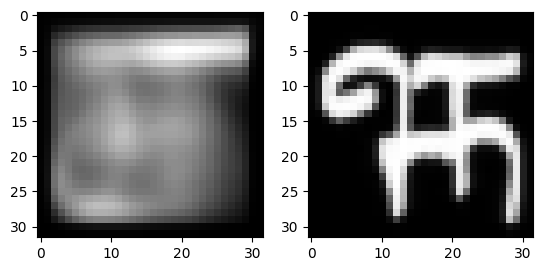

In [71]:
temp_features = features.numpy()
temp_ = temp_features.copy()
temp_features[:,:,:,:] = 0
temp_features[:,:,index,:] = temp_[:,:,index,:]

recon = model.regenerate_image(temp_features)
print(recon.shape,temp_features.shape)
recon = tf.reshape(recon, (32,32))

plt.subplot(1,2,1)
plt.imshow(recon, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(X_test[index_,:,:,0], cmap='gray')

In [50]:
col = np.zeros((32,352))
for i in range(16):
    feature_ = temp_features.copy()
    feature_[:,:,index, i] += -0.25
    row = np.zeros((32,32))
    for j in range(10):
        feature_[:,:,index, i] += 0.05
        row = np.hstack([row, tf.reshape(model.regenerate_image(tf.convert_to_tensor(feature_)), (32,32)).numpy()])
    col = np.vstack([col, row])

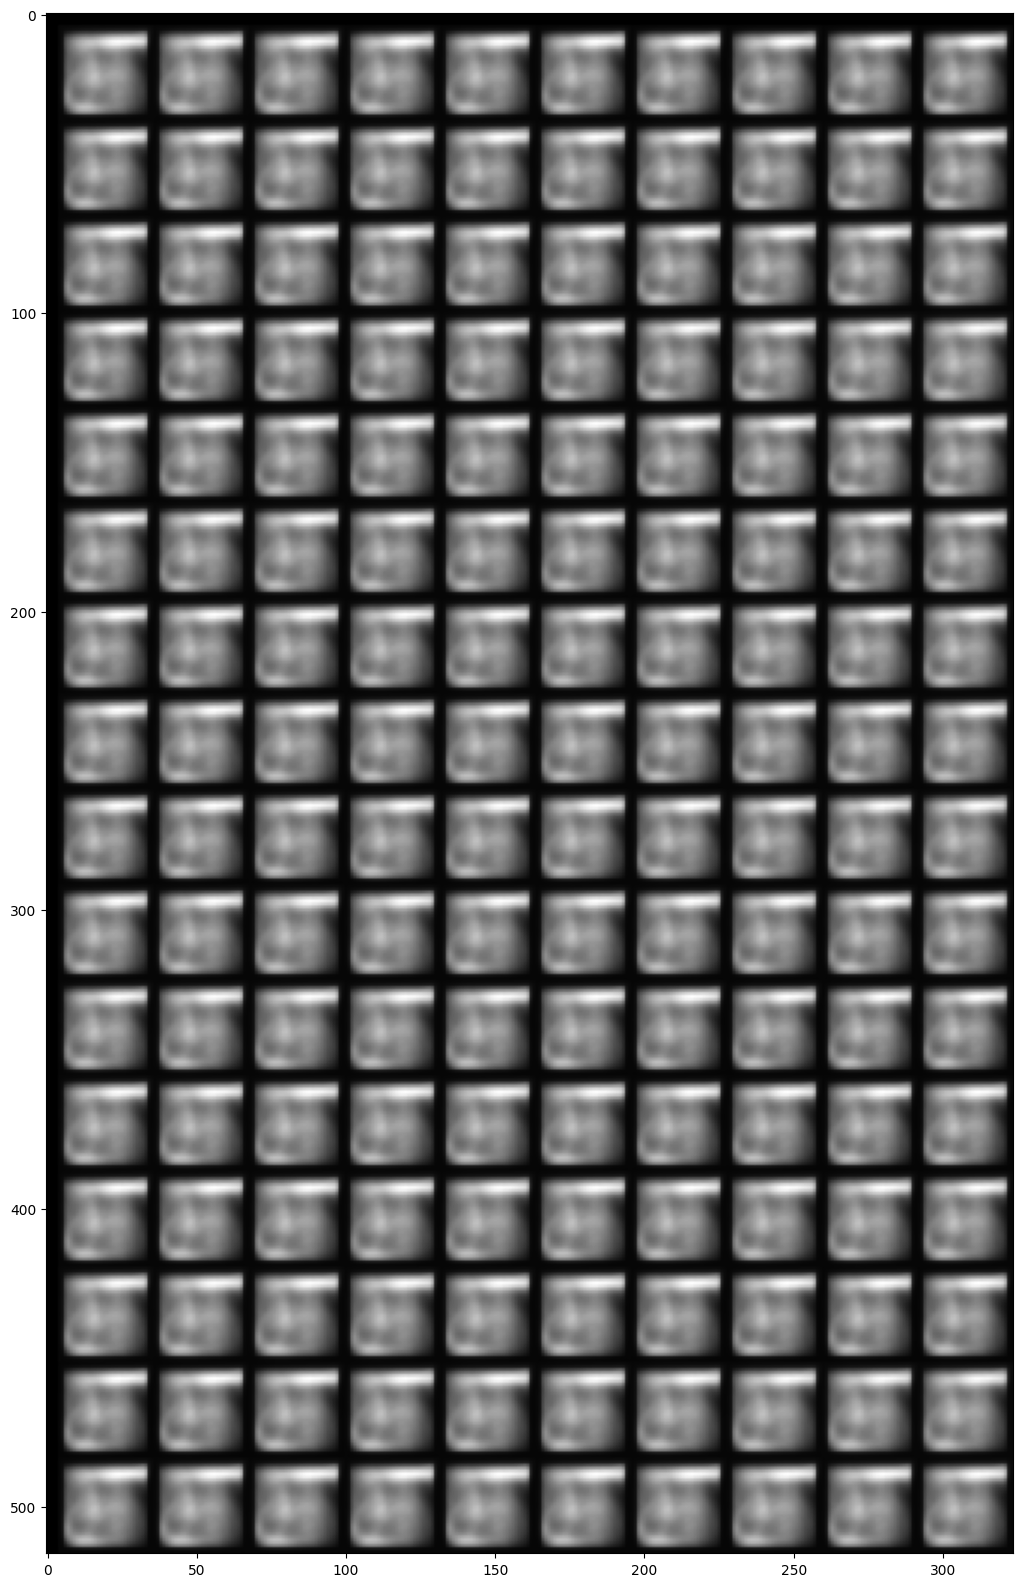

In [36]:
plt.figure(figsize=(30,20))
plt.imshow(col[28:, 28:], cmap='gray')